<p style="text-align: center"><a href='https://twinsolar.eu/'><img src="https://twinsolar.eu/wp-content/uploads/2023/03/logo_twinsolar_seul.png" width="200"><img src="https://twinsolar.eu/wp-content/uploads/2023/03/EN_FundedbytheEU_RGB_POS.png" width="200"></p></p></a>
<p style="text-align: center"><a href='https://twinsolar.eu/'>https://twinsolar.eu/</a></p>

# Workshop: Modelling individual components and a whole energy system, which integrates a large share of variable renewables

<h2>Part 1: PV system modelling</h2>

This Jupyter Notebook show a method to compute the module parameters used by the single diode model from the manufacturer datasheet based on the <a href = "https://pvlib-python.readthedocs.io">pvlib</a> library.

<h3>Assess module parameters from manufacturer datasheet and run the <a href='https://pvlib-python.readthedocs.io/en/v0.6.1/generated/pvlib.pvsystem.singlediode.html'>single diode model</a></h3>

To illustrate how to create the set of parameters from the manufacturer datasheet and to run the single diode, we selected the model of modules used for the ENERPOS PV plant: TENESOL TE2000 210Wp

In [1]:
# Init environement
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib

/Users/mdavid/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<h3>Define PV module</h3>

The polycristaline modules TENESOL TE2000 of the ENERPOS system are not present in CEC file provided with the pvlib library. The technical datasheet is available <a href = "TE220_TENESOL.pdf">here</a> (only in French). The table below provide the main characteristics of the modules.

| Characteristics                   | STC$^*$   | NOCT$^{**}$  |   | Characteristics     |              |
|-----------------------------------|-----------|--------------|---|---------------------|--------------|
| Typical peak power                |     210 W |      147.8 W |   | Power temp. coef.   |   -0.46 %/°C |
| Voltage at peak power ($V_{mp}$)  |    26.7 V |       24.4 V |   | Voltage temp. coef. | -116.1 mV/°C |
| Intensity at peak power ($I_{mp}$)|     7.5 A |        6.1 A |   | Current temp. coef. |   +4.4 mA/°C |
| Open circuit voltage ($V_{sc}$)   |    32.7 V |       30.5 V |   | Module length       |       1.51 m |
| Short circuit current ($I_{sc}$)  |     7.8 A |        6.5 V |   | Module width        |      0.995 m |
| Cell temperature                  |      25°C |         45°C |   | Number of cells     |           54 |

<font size=1>$^*$ Standard Test Conditions (STC): 1000 W/m$^2$, 1.5 AM, and cell temperature 25°C</font>

<font size=1>$^{**}$ NOCT test: 1000 W/m$^2$, 1.5 AM, ambiant temperature 20°C, and wind speed 1 m/s</font>

In [2]:
# Create module model from the datasheet
from pvlib import pvsystem

# Import module specs from custom CEC file
module_database = pvsystem.retrieve_sam(path = 'Custom-cec-modules.csv')
module = module_database.TENESOL_TE2000_210W

# Estimate the parameters for the CEC single diode model
""" WARNING - This function relies on NREL's SAM tool. So PySAM, its Python API, needs to be installed 
in the same computer. Otherwise, you can expect the following error: 'ImportError if NREL-PySAM is not installed.'
"""
module.I_L_ref, module.I_o_ref, module.R_s, module.R_sh_ref, module.a_ref, module.Adjust = pvlib.ivtools.sdm.fit_cec_sam(
    celltype = module.Technology,
    v_mp = module.V_mp_ref, 
    i_mp = module.I_mp_ref,
    v_oc = module.V_oc_ref, 
    i_sc = module.I_sc_ref, 
    alpha_sc = module.alpha_sc,
    beta_voc = module.beta_oc, 
    gamma_pmp = module.gamma_r,
    cells_in_series = module.N_s, 
    temp_ref = 25)

# Let's have a look to the module specs
print(module)

Technology       multiSi
Bifacial               0
STC                  210
PTC                147.8
A_c             1.325126
Length              1.51
Width              0.995
N_s                   54
I_sc_ref             8.0
V_oc_ref            32.9
I_mp_ref             7.5
V_mp_ref            26.7
alpha_sc          0.0044
beta_oc          -0.1161
T_NOCT              45.0
a_ref           1.397766
I_L_ref          8.00658
I_o_ref              0.0
R_s              0.28049
R_sh_ref      341.003245
Adjust          6.650831
gamma_r            -0.46
BIPV                   N
Version           Custom
Date          01/03/2019
Name: TENESOL_TE2000_210W, dtype: object


<h3>Generate IV curves with the single diode model</h3>

The IV curve of a PV module is one of the typical technical characteristics often available in datasheets. The script below build the IV characteristic curve of the PV module created previously using the <a href = 'https://pvlib-python.readthedocs.io/en/stable/user_guide/singlediode.html'>single diode equation</a>.

In order to build the IV curve, we need to estimate the 5 input parameters needed to perform the single diode equation that will return the I and V values for given values of effective irradiance and cell/module temperature.

[array([1.61363816, 3.22727632, 4.84091448, 6.45455264, 8.0681908 ]), array([5.24811943e-09, 5.24811943e-09, 5.24811943e-09, 5.24811943e-09,
       5.24811943e-09]), array([0.28048993, 0.28048993, 0.28048993, 0.28048993, 0.28048993]), array([1705.01622635,  852.50811318,  568.33874212,  426.25405659,
        341.00324527]), array([1.46808812, 1.46808812, 1.46808812, 1.46808812, 1.46808812])]


/Users/mdavid/Library/Python/3.9/lib/python/site-packages/pvlib/pvsystem.py:2476: pvlibDeprecationWarning: 
The pvlib.pvsystem.singlediode parameter ivcurve_pnts was deprecated in pvlib 0.10.0 and will be removed in 0.11.0. Use pvlib.pvsystem.v_from_i and pvlib.pvsystem.i_from_v instead.
  warn_deprecated('0.10.0', name='pvlib.pvsystem.singlediode',


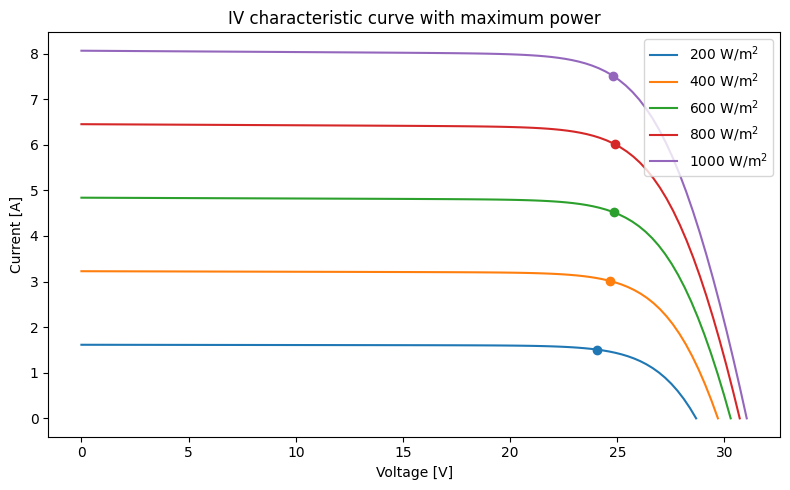

In [3]:
# Plot IV curves using the single diode model

# Effective irradiance values (W/m2)
E_irrad = np.array([200,400,600,800,1000])
# Average cell temperature (degrees Celsius)
T_cell = np.array([40, 40, 40, 40, 40])

# Estimate the 5 parameters of the single diode equation using the CEC model
SDparam = pvsystem.calcparams_cec(effective_irradiance = E_irrad,
                                  temp_cell = T_cell,
                                  alpha_sc = module.alpha_sc,
                                  a_ref = module.a_ref,
                                  I_L_ref = module.I_L_ref,
                                  I_o_ref = module.I_o_ref,
                                  R_sh_ref = module.R_sh_ref,
                                  R_s = module.R_s,
                                  Adjust = module.Adjust)

print(SDparam)

# Estimate IV characteristic using the Single Diode Equation
iv_values = pvlib.pvsystem.singlediode(SDparam[0], 
                                        SDparam[1], 
                                        SDparam[2], 
                                        SDparam[3], 
                                        SDparam[4],
                                        ivcurve_pnts=100, # Number of points of the IV curve
                                        method='lambertw') # IV using the Lambert W. function

# Plot results
plt.figure(figsize=(8,5))
for i in range(len(E_irrad)):
    plt.plot(iv_values['v'][i], iv_values['i'][i], label=str(E_irrad[i])+' W/m$^2$')
    plt.scatter(iv_values['v_mp'][i], iv_values['i_mp'][i])
# Add the title, axis labels and legend: 
plt.title('IV characteristic curve with maximum power')
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
# plt.ylim(0, 10)
plt.legend()
plt.tight_layout()